In [19]:
%matplotlib inline
import pysam
import pandas as pd
import numpy as np
import matplotlib
import sys
import os
#matplotlib.use('Agg')
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO
from intervaltree import Interval, IntervalTree
import glob
np.random.seed(0)
import os
import sys

ODIR="plots"
os.makedirs(ODIR, exist_ok=True)

# color map 
cmap  = {"sqII.clr":"#6FC1E3", 'ccs':"#3a3535", 'rel3.ontucd':"#6DDA96",  'rel3.ontuwashington':"#a35638" }
# minimum homopolymer length to look at
MIN_LEN_HP=5

In [3]:
### READ IN THE READ LENGTH AND QUALITY DATA ###

tdf = pd.read_csv("results/all.txt", sep="\t", names=["length", "read_id", "matchID", "indelID","platform", "contig"])

# calculate QV from the identity of the alignment 
tdf["basepair QV"] = -10 * np.log10( 1 - tdf["matchID"] )
tdf["indel QV"] = -10 * np.log10( 1 - tdf["indelID"] )

# Note that on the plot we labeled QV 43 as "prefect" reads
tdf["basepair QV"].replace([np.inf, -np.inf, np.nan], 43, inplace=True)
tdf["indel QV"].replace([np.inf, -np.inf, np.nan], 43, inplace=True)


tdf["indelID"] = tdf["indelID"]*100

# associate ont read ids by the center they came from 
dfs = []
for file in glob.glob("../data/rel3_ont/*.ids"):
    tag = os.path.basename(file)[:-4]
    tmp = pd.read_csv(file, names=["read_id"])
    tmp["center"] = tag
    dfs.append(tmp)

reads_by_center = pd.concat(dfs, ignore_index=True)

df = pd.merge(tdf, reads_by_center, how="left", on=["read_id"])
df.center.fillna('', inplace=True)
df["platform"] = df.platform + df.center

df.platform.unique()

# make different data frames for length and accuracy 
for_len = df 
for_qv = df 
if("chrX_v0.8|arrow|arrow" in for_len.contig):
    for_len[for_len.contig ==  "chrX_v0.8|arrow|arrow"]
    

/net/eichler/vol26/7200/software/modules-sw/miniconda/4.5.12/Linux/RHEL6/x86_64/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/net/eichler/vol26/7200/software/modules-sw/miniconda/4.5.12/Linux/RHEL6/x86_64/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


In [4]:
# custom histogram plotting function
def plot_hist(df, log=False, nbins=None,  column = "length", alpha = 1, ax=None, ylab=None, xlab=None,right=None, xmax = None, **kwargs):
    if(ax is None):
        fig, ax = plt.subplots(1,1, figsize=(16,9))
    tmax=0
    tmax=df[column].max()
    nbins=50
    
    for tech in df.platform.unique():
        color = None
        if(tech in cmap):
            color = cmap[tech]
        
        tmin = 0
        if(column =="indel QV"):
            tmin=3; tmax=45
            nbins = 43*5
        if(column == "length"):
            if(right):
                tmax = np.ceil( right/1000   )*1000
            else:
                tmax = np.ceil( df[column][df.platform == tech].max()/1000   )*1000
            nbins = tmax/1000 +1
            
       
        if(log):
            tmin = 100 #df[column].min()
            if(column=="indelID"): tmin = 50
            print( np.log10(tmin),np.log10(tmax) , tmin, tmax)
            bins = np.logspace(np.log10(tmin),np.log10(tmax), 200) 
        else:
             bins = np.linspace(tmin, tmax, nbins)
        
        touse = df[column][df.platform == tech]
        total = len(touse)
        sns.distplot(touse, ax = ax, bins=bins, color=color, 
                     hist_kws=dict(edgecolor="k", linewidth=0.25, alpha=alpha, weights=np.ones(total)*1./total ), 
                     **kwargs, label=tech)
        
    if(log):
        ax.set_xscale("log")

    ax.get_xaxis().set_major_formatter( matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    sns.despine(ax=ax)

    if(column == "indel QV"):
        ax.set_xlim(left=3, right=45)
        ax.set_xticklabels( [  "{:.2f}".format(  100* (1 - 10**(-QV/10)   ))  for QV in ax.get_xticks() ] )
        
    if(column == "length"):
        ax.set_xlim(left=0)
    
    if(xlab):
        ax.set_xlabel(xlab)
    if(ylab):
        ax.set_ylabel(ylab)
    ax.legend(loc='upper right')
    return(ax)



2.0 6.819478128362123 100 6599000.0


/net/eichler/vol26/7200/software/modules-sw/miniconda/4.5.12/Linux/RHEL6/x86_64/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


2.0 6.819478128362123 100 6599000.0


/net/eichler/vol26/7200/software/modules-sw/miniconda/4.5.12/Linux/RHEL6/x86_64/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


2.0 6.819478128362123 100 6599000.0


/net/eichler/vol26/7200/software/modules-sw/miniconda/4.5.12/Linux/RHEL6/x86_64/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


2.0 6.819478128362123 100 6599000.0


/net/eichler/vol26/7200/software/modules-sw/miniconda/4.5.12/Linux/RHEL6/x86_64/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


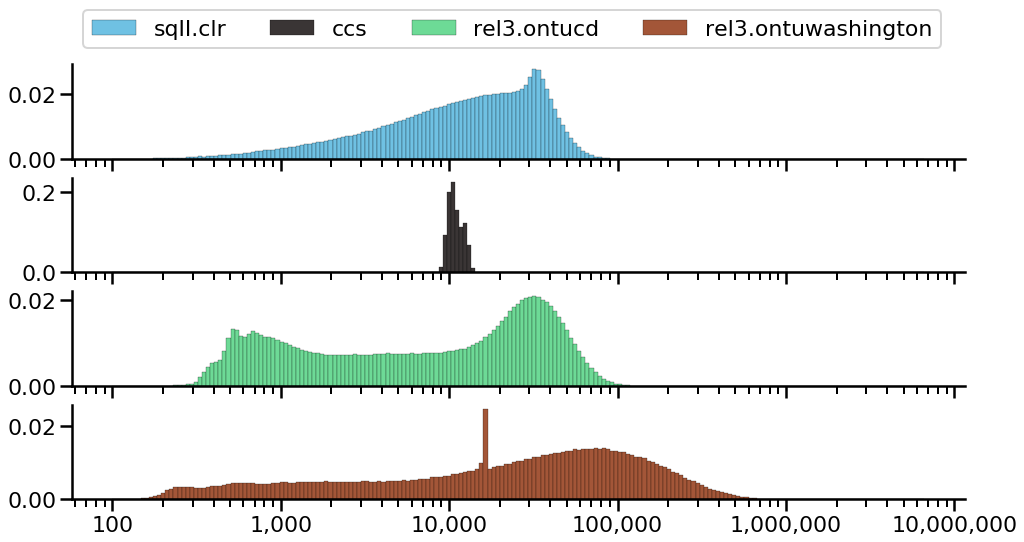

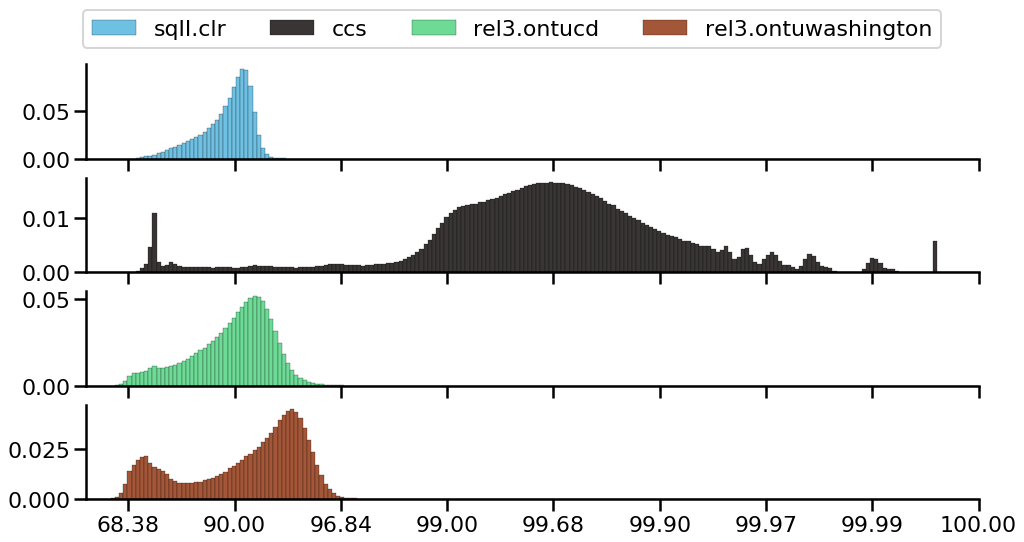

In [15]:
# Make plots for length and accuracy 
sns.set_context("poster")
touse = ["sqII.clr","ccs", "rel3.ontucd", 'rel3.ontuwashington']
right = for_len.length.max()
fig, axs = plt.subplots(len(touse), 1, figsize=(16,8), sharex=True)
for ax, plat in zip(axs, touse ):
    plot_hist(for_len[for_len.platform==plat ], 
              ax=ax, log=True, alpha =1, kde=False, right = right)
    ax.set_xlabel(""); ax.set_ylabel(""); ax.get_legend().remove()

fig.legend(loc="upper center", ncol=len(touse))
plt.savefig(f"{ODIR}/combo.length_2.pdf")
plt.savefig(f"{ODIR}/combo.length_2.png", dpi=300)

fig, axs = plt.subplots(len(touse), 1, figsize=(16,8), sharex=True)
for ax, plat in zip(axs, touse ):
    plot_hist(for_len[for_len.platform==plat ], ax=ax, column="indel QV", alpha =1, kde=False)
    ax.set_xlabel(""); ax.set_ylabel(""); ax.get_legend().remove()

fig.legend(loc="upper center", ncol=len(touse))
plt.savefig(f"{ODIR}/combo.accuracy_2.pdf")
plt.savefig(f"{ODIR}/combo.accuracy_2.png", dpi=300)


In [134]:
def NX(data, xs):
    xs.sort()
    mult =  [x*1.0/100 for x in xs ]
    s = sorted(list(data), reverse = True)
    total = sum(s)
    cur = 0
    index = 0
    rtn = []
    for val in s:
        cur += val
        if(cur > total*mult[index]):
            rtn.append( (val, xs[index]) )
            index += 1
            if(index == len(xs)):
                break
    return(rtn)

def get_stats(df):
    out = ""
    for platform, group in df.groupby("platform"):
        out += platform + "\n"
        #print(group["length"].describe())
        #print( "min:{}\nmax:{}".format(group["length"].min(),group["length"].max() ))
        for N, x in NX(group["length"], [1,5,10, 25, 50, 75, 90, 95, 99]):
            out += "N{} {}\n".format(x, N)
        
        for_qv = group[group.contig ==  "chrX_v0.8|arrow|arrow"]
        out += "accuracy stats:\n"
        out +=  str(for_qv["indelID"].describe())
        out += "\n\n"

    return(out)


rtn = get_stats(df)
open("stats.txt", "w+").write(rtn)
print(rtn)

ccs
N1 13609
N5 13103
N10 12762
N25 12016
N50 10860
N75 10175
N90 9714
N95 9475
N99 9117
accuracy stats:
count    331750.000000
mean         99.789657
std           0.421530
min          74.548667
25%          99.723024
50%          99.919668
75%          99.973290
max         100.000000
Name: indelID, dtype: float64

rel3.ontnhgri
N1 366928
N5 242913
N10 192736
N25 127505
N50 74644
N75 39035
N90 19093
N95 12711
N99 4808
accuracy stats:
count    255831.000000
mean         90.311426
std           7.223082
min          49.934564
25%          88.398082
50%          93.287769
75%          95.247889
max         100.000000
Name: indelID, dtype: float64

rel3.ontucd
N1 93655
N5 72835
N10 63066
N25 48711
N50 35176
N75 23424
N90 12282
N95 6343
N99 1263
accuracy stats:
count    298323.000000
mean         89.435221
std           5.247332
min          50.000000
25%          87.810021
50%          91.165310
75%          92.870509
max         100.000000
Name: indelID, dtype: float64

rel3.ontunottin

In [21]:
### READ IN THE READ LENGTH AND QUALITY DATA ###

def convert_to_simple(mat):
    print(mat.shape)
    nr, nc = mat.shape
    by_pos = {}
    for i in range(nr):
        if(i < MIN_LEN_HP ):
            continue 
        for j in range(nc):
            diff = j-i
            if(diff not in by_pos):
                by_pos[diff] = 0.0
            by_pos[diff] += mat[i, j]
    #print(by_pos)
    total = sum(by_pos.values()); x = []; y = []
    for key in by_pos:
        x.append(key); y.append(by_pos[key]/total * 100 )

    return( (x, y) )
    
# load matrix where cells represent coutns and row and oclumns represent observed hp length and real hp count.
# e.g. accurate reads fall on the digaonal of this matrix
ccs = np.load("results/ccs.mat.npy")
sqII = np.load("results/sqII.clr.mat.npy")
#ontucd = np.load("temp/rel3.ontucd.mat.npy")
#ontuw = np.load("temp/rel3.ontuwashington.mat.npy")

# merge matrix of HP error into a simple dataframe     
tmp = {"x":[], "y":[], "label":[]}
for mat, label in  zip([sqII, ccs], ["sqII.clr", "ccs"]):
    x, y = convert_to_simple(mat)
    labels = [label] *len(x)
    tmp["x"] += x
    tmp["y"] += y
    tmp["label"] += labels

df = pd.DataFrame(tmp)

(100, 110)
(100, 110)


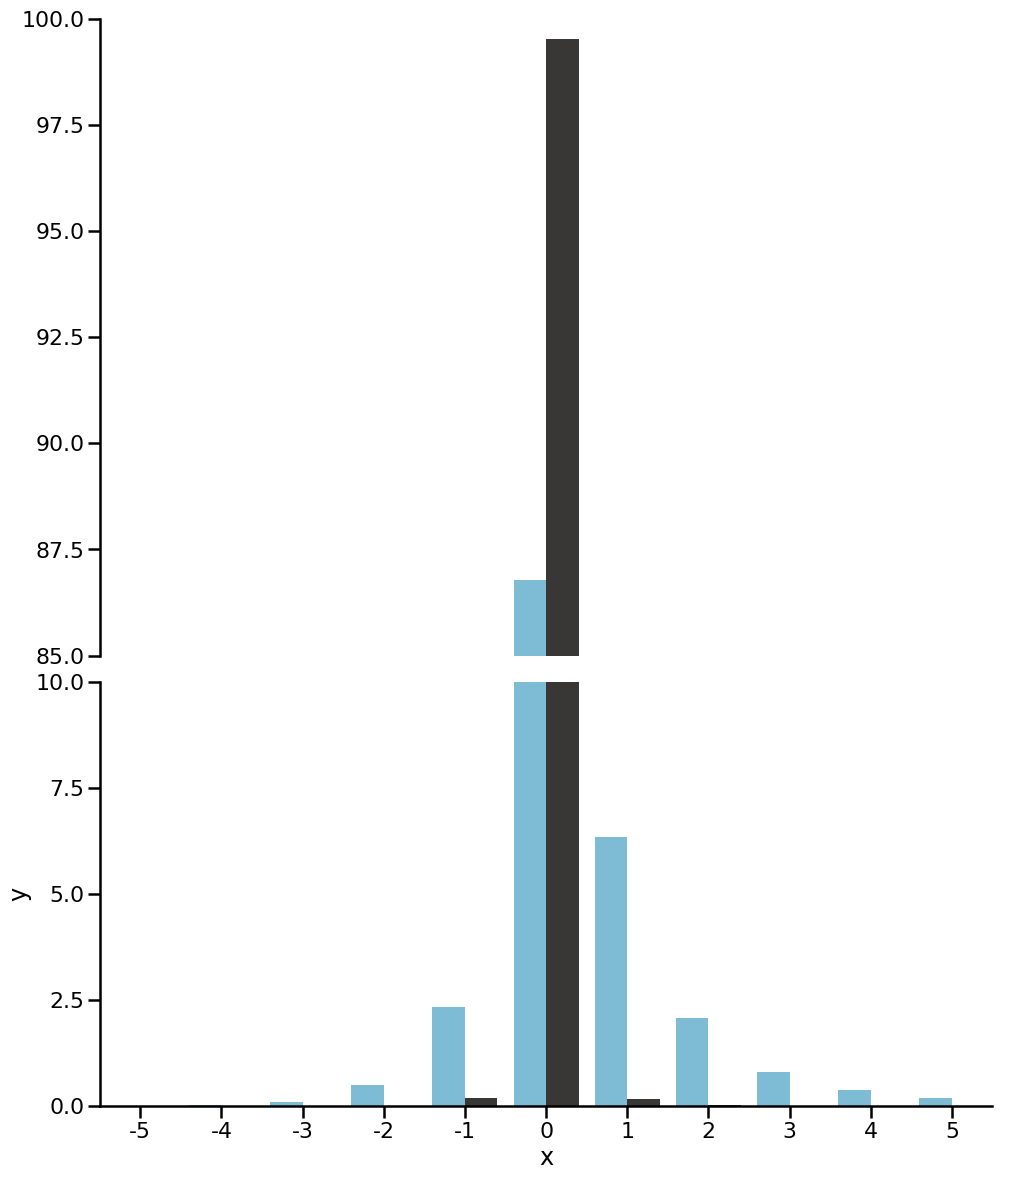

In [22]:
lim = MIN_LEN_HP + 1
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,20), gridspec_kw={'height_ratios': [1.5, 1]})
fig.subplots_adjust(hspace=0.05)



for ax, bot, top in zip( [ax1, ax2], [85, 0], [100, 10]):
    sns.barplot(x="x", y="y", hue="label", palette=cmap, data=df[ df.x.abs() < lim  ] , ax = ax)
    for p in ax.patches:
        y = p.get_height()
        x = p.get_x()
        w = p.get_width()
        if(  y < top and y > bot and y > 0.1 ):
            tmp_fake=None
            #ax.text(x, y, "{:.1f}".format(y), fontsize=16, rotation = 60, va = "bottom")
            
            
    ax.get_legend().remove()
    if(bot != 0 ):
        ax.get_xaxis().set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_ylabel("")
    else:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    #ax.set_xlim(left=-6, right =6)
    ax.set_yticks( np.arange(bot,top+2.5, 2.5) )
    
    ax.set_ylim(top=top, bottom = bot)

#fig.legend(loc="lower center", ncol=len(df.label.unique()))

plt.savefig(f"{ODIR}/Hist_homo.png", dpi=300)
plt.savefig(f"{ODIR}/Hist_homo.pdf")
